## Optics simulation (full)
From telescope entrance to focal plane after Lyot plane.
No aberrations

In [4]:
%%capture
%load_ext autoreload
%autoreload 2

from __future__ import division
exec(open('./prep.py'))
exec(open('./codes/func.py'))
exec(open('./codes/util.py'))
exec(open('./codes/opt.py'))
% matplotlib inline

In [8]:
primary_path  = '../masks/gemini_primary.fits'

## Y band - 1.02 um
apod_y_path = '../masks/gpi_y_apodizer.fits'
lyot_y_path = '../masks/gpi_y_lyot.fits'
fpm_y_path = '../masks/gpi_y_fpm.fits'
## J band - 1.22 um
apod_j_path = '../masks/gpi_j_apodizer.fits'
lyot_j_path = '../masks/gpi_j_lyot.fits'
fpm_j_path = '../masks/gpi_j_fpm.fits'
## H band - 1.65 um
apod_h_path = '../masks/gpi_h_apodizer.fits'
lyot_h_path = '../masks/gpi_h_lyot.fits'
fpm_h_path = '../masks/gpi_h_fpm.fits'
## K band - 2.19 um ; use K1
apod_k_path = '../masks/gpi_k1_apodizer.fits'
lyot_k_path = '../masks/gpi_k1_lyot.fits'
fpm_k_path = '../masks/gpi_k1_fpm.fits'

## Y-band

In [9]:
Y_band = APLC_sim(wavelength=1.02*u.um)

In [10]:
Y_band.setPath(primary_path,apod_y_path,fpm_y_path,lyot_y_path)

N_pix is 1276


### masks

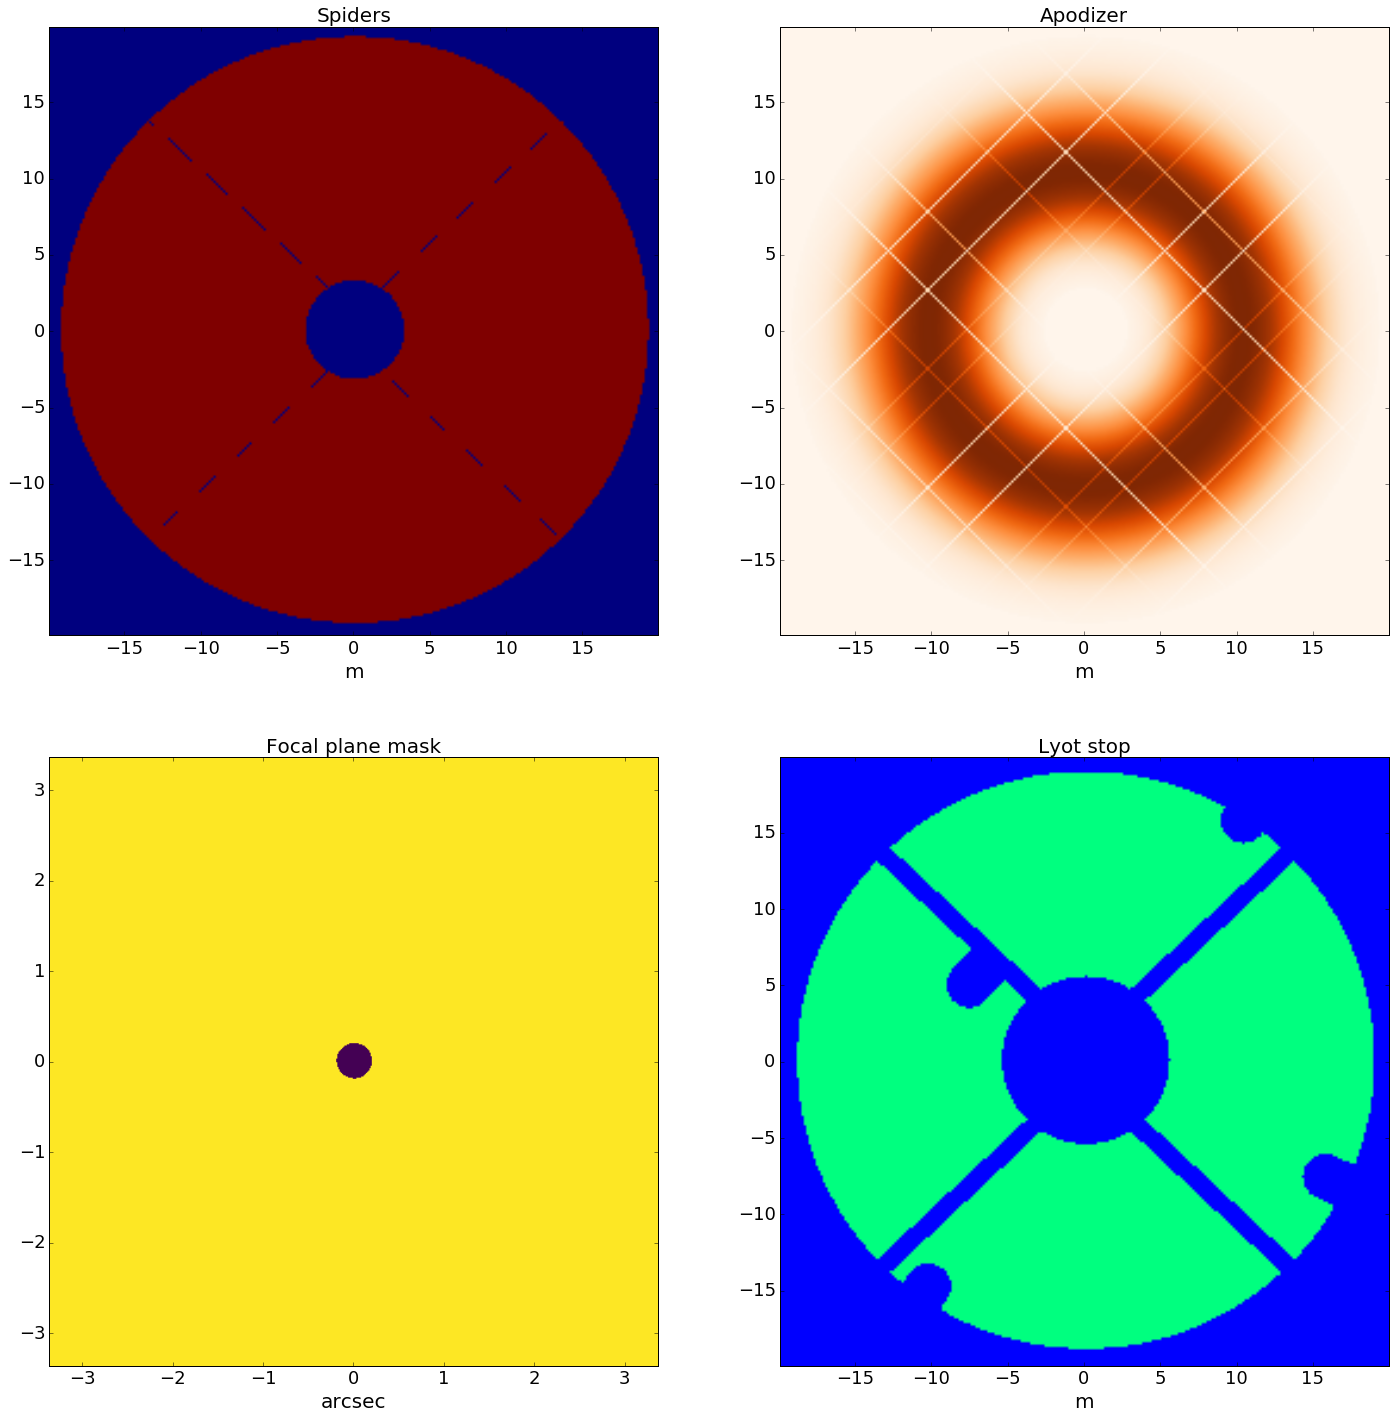

In [11]:
Y_band.plot_mask()

### Some numbers and plots
#### primary mirror

In [12]:
Y_band.D_tel

<Quantity 7.6875 m>

#### Apodizer

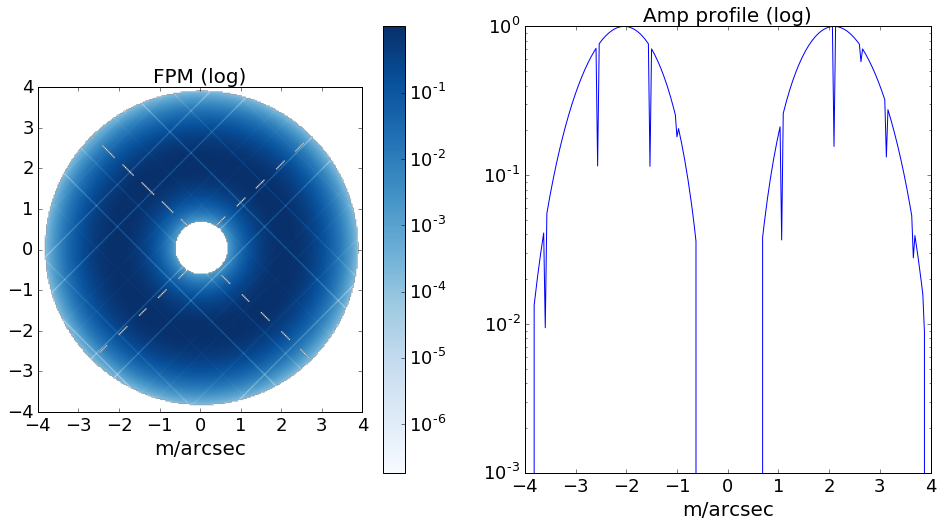

In [14]:
## have to run first
plot_profile(Y_band.Str_apo_ef,extent=(Y_band.px_min,Y_band.px_max),limit=(-4,4))

The left is also what the incident light would look like. 

---
## Run!
Besides a star, another default input is a planet located 0.6 arcsec away from the star. It is characterized by a tilt in phase, and is assumed to have $10^{-5}$ intensity

In [13]:
Y_band.run()

Done first image plane. It took me 0.717 s
Done second pupil plane. It took me 0.764 s
Done final image plane. It took me 0.685 s


### First image plane

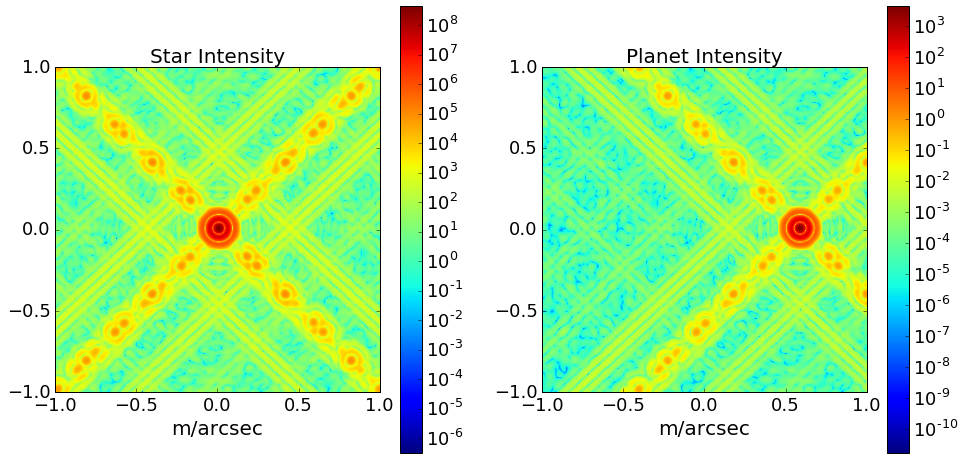

In [15]:
plot_stage(Y_band.Str_ffoc_ef,Y_band.Pnt_ffoc_ef,extent=(Y_band.kx_min,Y_band.kx_max),limit=(-1,1),log=True)

The intensity ratio of the star and the satellites is around $10^4$, consistent with "actuality". Good sign.
We can also see (part of) the "rectangular" strips, as in Perrin's [simulator](https://github.com/geminiplanetimager/gpipsfs/blob/master/notebooks/Getting%20Started%20with%20GPI%20PSFs.ipynb).


Alright, the planet's phase shift causes the shift of the image on the focal plane. Hence applying coronagraph below will remove the un-shifted star contribution:

### Focal plane mask

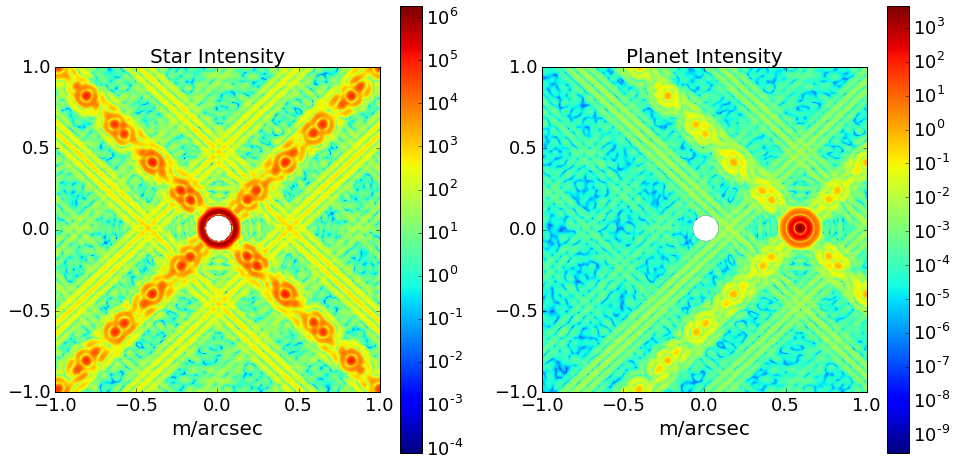

In [16]:
plot_stage(Y_band.Str_coro_ef,Y_band.Pnt_coro_ef,extent=(Y_band.kx_min,Y_band.kx_max),limit=(-1,1),log=True)

Looks nice! The mask roughly matches the size of the first blob of the diffraction pattern and leaves the other features intact. (Indeed, the mask size in `arcsec` agrees with the documented specifications (e.g. [here](http://docs.planetimager.org/pipeline_dev/gpi_pipeline/documentation/gpireference/coronagraph.html#coronagraph-apodizer))

The planet remains "visible", and the angular separation from the star is consistent with the input.

### Lyot stop

#### Second pupil plane (before)

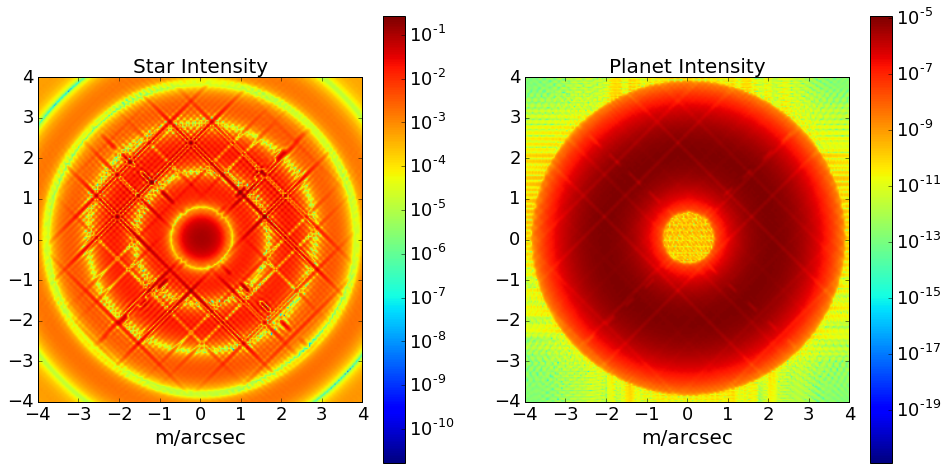

In [17]:
plot_stage(Y_band.Str_2pup_ef,Y_band.Pnt_2pup_ef,extent=(Y_band.px_min,Y_band.px_max),limit=(-4,4),log=True)

The star, zoomed out

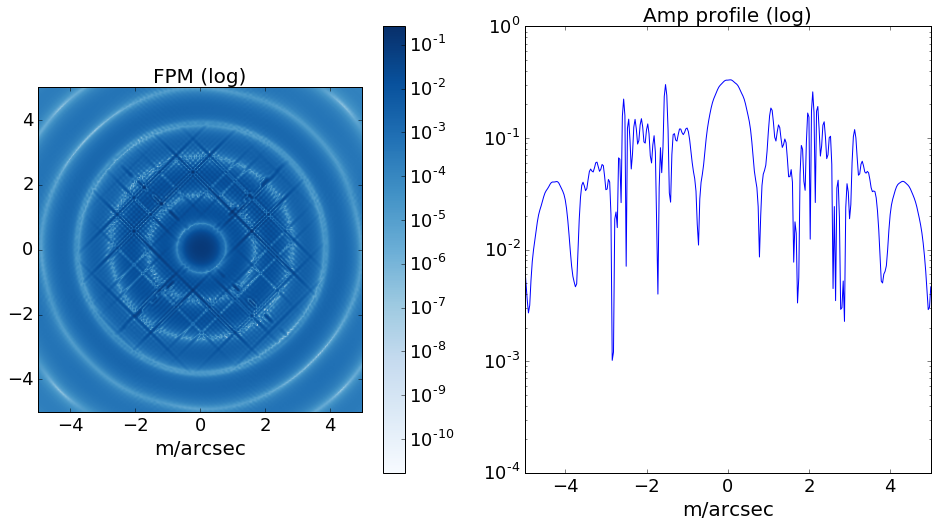

In [18]:
plot_profile(Y_band.Str_2pup_ef,extent=(Y_band.px_min,Y_band.px_max),limit=(-5,5))

There is still no obvious "outer ring" as commonly reported in APLC papers (e.g. Martinez [2010](http://doi.org/10.1051/0004-6361/201014818) and Soummer+[2011](http://doi.org/10.1088/0004-637X/729/2/144), which is kind of curious. But anyway, wa want to remove the other ripples as well, leaving only the annulus

#### Applying Lyot 

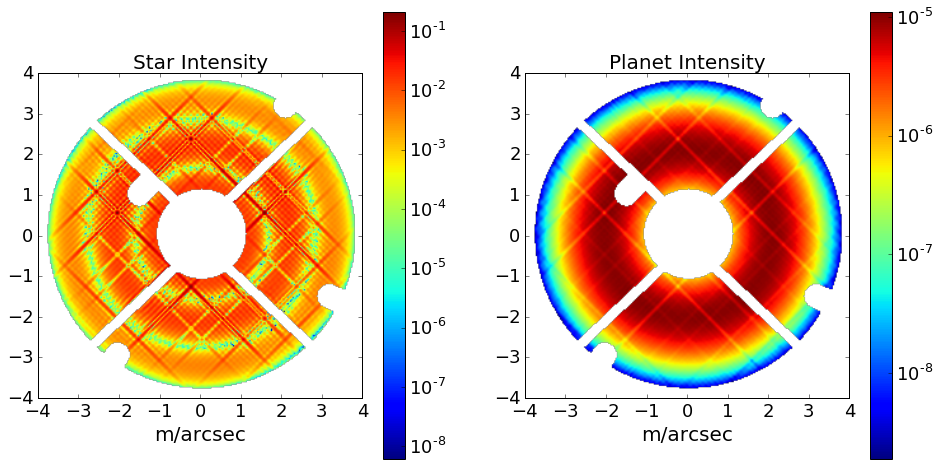

In [19]:
plot_stage(Y_band.Str_lyo_ef,Y_band.Pnt_lyo_ef,extent=(Y_band.px_min,Y_band.px_max),limit=(-4,4),log=True)

In linear scale

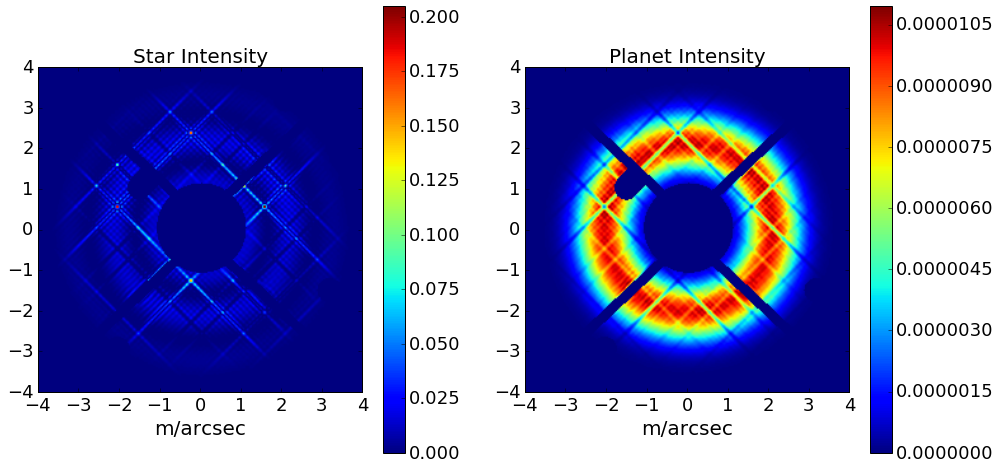

In [20]:
plot_stage(Y_band.Str_lyo_ef,Y_band.Pnt_lyo_ef,extent=(Y_band.px_min,Y_band.px_max),limit=(-4,4))

OKay, most star light has been blocked away.

### Final image

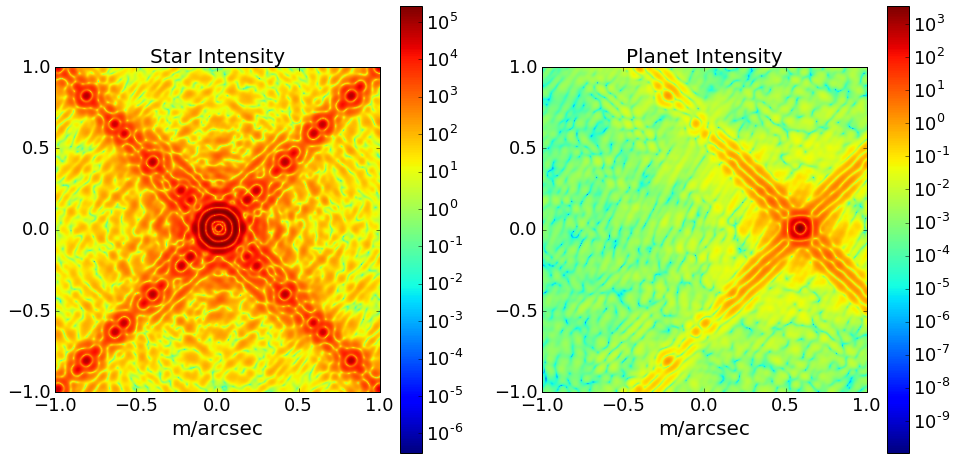

In [21]:
plot_stage(Y_band.Str_final_ef,Y_band.Pnt_final_ef,extent=(Y_band.kx_min,Y_band.kx_max),limit=(-1,1),log=True)

Something worth noting: the peak intensity of the $10^{-5}$ dimmer planet is only one-hundreth of that of the residual star light. This means the contrast has been improved pretty well, but not perfect. I suppose this has to do with the demand of broadband optimization and the chosen wavelength might just happen to not be the best

### Combining the two
#### Contrast
Definition: Coronagraphic PSF normalized by the peak of an off-axis source that is not affected by the FPM (Soummer+[2011](http://iopscience.iop.org/article/10.1088/0004-637X/729/2/144/meta))

In [22]:
Y_band.contrast()

Star   peak int. = 2.62e+05
Planet peak int. = 3.45e+08

Contrast at zero radius = 7.61e-04


Look good? Let's plot out the radial dependence

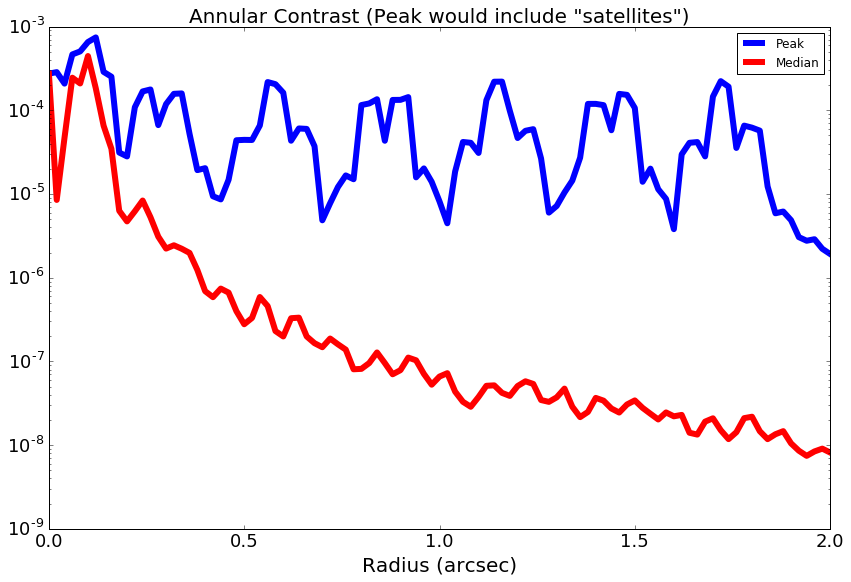

In [23]:
plt.figure(figsize=(14,9))
plt.plot(Y_band.contrast_pk[0],Y_band.contrast_pk[1],'b',linewidth=6,label="Peak")
plt.plot(Y_band.contrast_md[0],Y_band.contrast_md[1],'r',linewidth=6,label="Median")
plt.title('Annular Contrast (Peak would include "satellites")')
plt.legend(); plt.yscale('log')
plt.xlabel('Radius (arcsec)')

Not very promising... I would expect the contrast to be as low as $10^{-8}$ at the planet radius, given that we do not have any aberrations thus far. Nevertheless, I think a good sign is that the peak contrast is almost uniform, which is also saying that the star light is diminished to roughly as faint as the satellites

### Combination

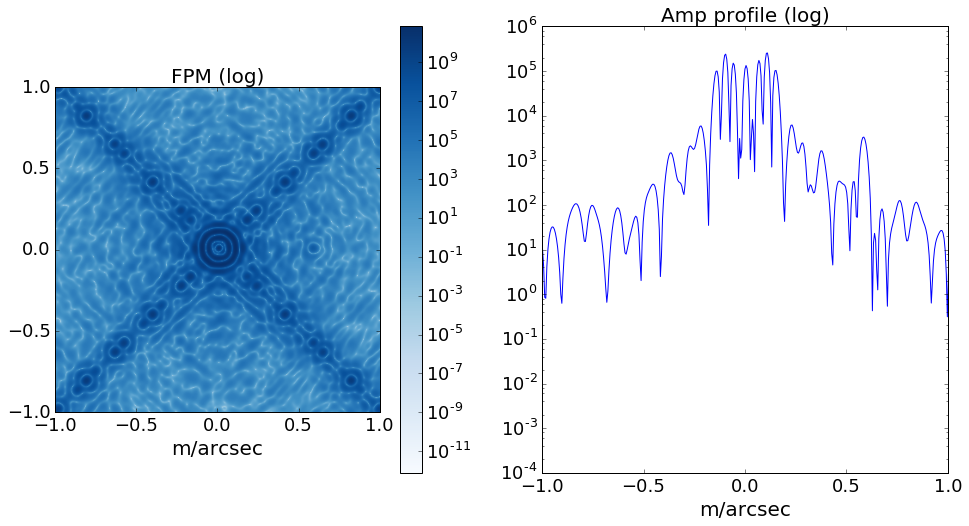

In [48]:
plot_profile(Y_band.cb_final_int,extent=(Y_band.kx_min,Y_band.kx_max),limit=(-1,1))

See the planet? I do!